# FastCLIP Score Test on COCO Val 2014

We want to quantify the search results of different models on COCO Val 2014 dataset.

There are three types of search we would like to conduct:

> 1. Text to Image
> 2. Image to Image
> 3. Image to Text



### Image Dataset loading

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pylab
import glob
import os
from marqo import Client

MODEL = "ViT-L/14"

dataDir='./'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
#print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
#print('COCO supercategories: \n{}'.format(' '.join(nms)))


docker_path = 'http://[::]:8224/'
images_directory = 'images'

files = glob.glob(images_directory + "/*.jpg")
files_map = {os.path.basename(f):f for f in files}

files_docker = [f.replace(images_directory, docker_path) for f in files]

documents = [{"image_docker":file_docker, '_id':os.path.basename(file_docker)} 
             for file_docker,file_local in zip(files_docker, files)]


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


### Index the images 

In [2]:
client = Client(url='http://localhost:8882')

index_name = 'coco-2017-val'

client.delete_index(index_name)

settings = {
        "model": MODEL,
        "treat_urls_and_pointers_as_images": True,
        }
try:
    client.create_index(index_name, **settings)
except:
    client.delete_index(index_name)
    client.create_index(index_name, **settings)
    
    

In [ ]:
client.index(index_name).add_documents(documents, device='cpu', processes=4, client_batch_size= 1)

I clear the outputs to reduce the file size. 

The average time for each document is 335ms (client_batch_size = 50)
The average time for each document is 345ms (client_batch_size = 10)
The average time for each document is 672ms (client_batch_size = 1).

# Text to Image Search Evaluation

The way we generate the searching query is randomly selecting several (1 to 3) labels and merge them into a string. For example, if we pick the labels "person" and "cat", the search query will be "person cat", and this is defined as a 2-label query.

We evalute the performances on 1-label query, 2-label query, 3-label query.

For a $n$-label query with $R$ resutls, the score is computed as

$$Score(n, M) = \sum_{i = 1} ^{R}\frac{100}{R^*}\times \frac{1}{n}\times Matched\,labels(result_i, groundtruth_i), $$

where $R^*$ is the expected number of results. 

$$R^* = \min \{R, \text{number of images with}\,n-\text{label}\}. $$

For exmaple, if the number of images with label "cat", "person" is __5__, and the $R = 10$, then $R^* = 5$. However, if the number of images is __40__ but $R = 10$, then $R^*$ = 10


The full mark is always __100__.


In [5]:
label1_list = [("person",), ("umbrella",), ("book",), ("sandwich",)]
label2_list = [("person", "cat",), ("pizza", "fork",), ("person", "bicycle",), ("cake", "knife",)]
label3_list = [("person", "dog", "sports",), ("person", "laptop", "phone",), ("suitcase", "light", "person",)]

label_list = label1_list + label2_list + label3_list

In [6]:
# Category Ids
for label_pairs in label_list:
    catIds = coco.getCatIds(catNms=label_pairs)
    # print the number of images including these labels
    imgIds = coco.getImgIds(catIds=catIds )
    print(len(imgIds))

2693
174
230
98
23
46
122
38
76
80
76


The label pair we choose can always return more than 10 images, and $R = 10$ in our search. So each search result worths 10 points, and each label worths $10 / n$ points

In [7]:
label_list

[('person',),
 ('umbrella',),
 ('book',),
 ('sandwich',),
 ('person', 'cat'),
 ('pizza', 'fork'),
 ('person', 'bicycle'),
 ('cake', 'knife'),
 ('person', 'dog', 'sports'),
 ('person', 'laptop', 'phone'),
 ('suitcase', 'light', 'person')]

### Text-to-image search result

In [8]:
for label_pair in label_list:
    search_string = "a " + " and ".join(label_pair)
    search_results = client.index("coco-2017-val").search(search_string, 
                        searchable_attributes=['image_docker'], 
                         device='cpu')
    score = 0
    
    for result in search_results["hits"]:
        img_id = int(result["_id"][6:12])
        anns = coco.loadAnns(coco.getAnnIds(imgIds = img_id))
        result_cat = []
        for an in anns:
            cat = coco.loadCats(an["category_id"])[0]
            result_cat.append(cat['name'])
        
        score += 10 * len(set(label_pair) & set(result_cat)) / len(label_pair)
        
    print(f"The score for searching \"{search_string}\" is {round(score)} %.")
        
    
        
        
        

The score for searching "a person" is 90 %.
The score for searching "a umbrella" is 100 %.
The score for searching "a book" is 100 %.
The score for searching "a sandwich" is 100 %.
The score for searching "a person and cat" is 100 %.
The score for searching "a pizza and fork" is 75 %.
The score for searching "a person and bicycle" is 75 %.
The score for searching "a cake and knife" is 80 %.
The score for searching "a person and dog and sports" is 57 %.
The score for searching "a person and laptop and phone" is 40 %.
The score for searching "a suitcase and light and person" is 60 %.


## Image to Image Search

Similarly, the queried images should have similar labels with the original one.

In [9]:
image_search_labels = label2_list.copy()

image_search_labels

[('person', 'cat'),
 ('pizza', 'fork'),
 ('person', 'bicycle'),
 ('cake', 'knife')]

In [10]:
start_image_id = []

for label_pairs in image_search_labels:
    catIds = coco.getCatIds(catNms=label_pairs)
    # print the number of images including these labels
    imgIds = coco.getImgIds(catIds=catIds)
    start_image_id.append(imgIds[0])
    
start_image_id




[223747, 312192, 184324, 376322]

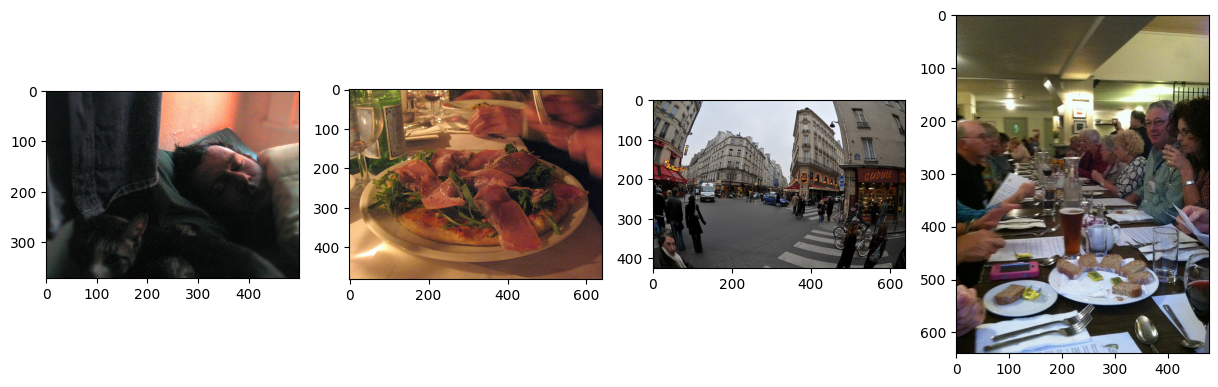

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(15,8))

imgs_name = [coco.loadImgs(id_number)[0]["file_name"] for id_number in start_image_id]

for i, img_name in enumerate(imgs_name):
    local_path_img_name = images_directory +"/" + img_name
    img = Image.open(local_path_img_name)
    axes[i].imshow(img)
plt.show()

In [12]:
imgs_name

['000000223747.jpg',
 '000000312192.jpg',
 '000000184324.jpg',
 '000000376322.jpg']

### Image-to-image search result

The way we score the the image-to-image search is to find the same number of labels between the original image and the searched iamge, and normalize it by the total number of label.

__Note: I think it's not a good idea to score image_to_image search. I didn't find a good way to quantify this similarity between images. The matching between text labels can not demonstrate our visual feelings.__

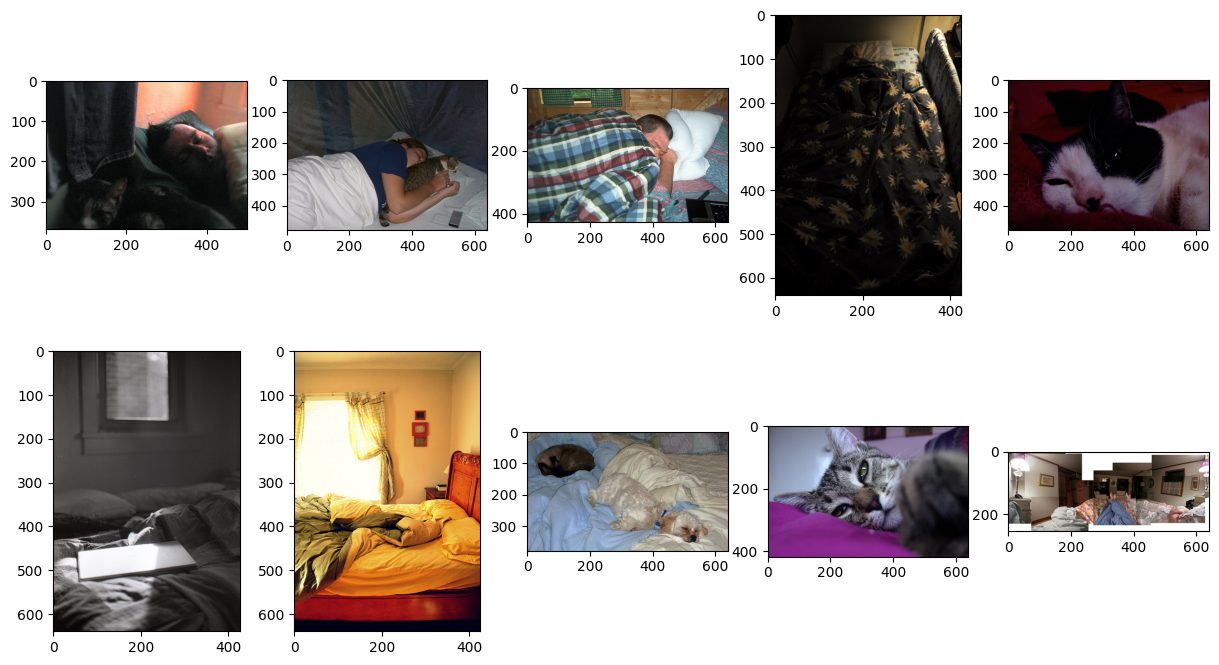

The score for searching "('person', 'cat')" is 50 %.


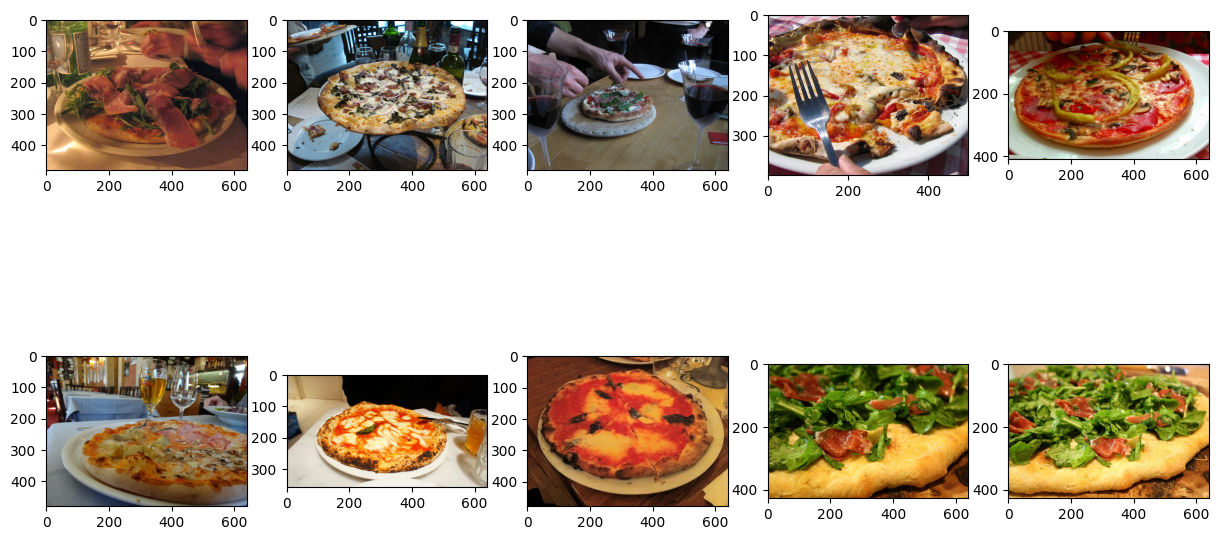

The score for searching "('pizza', 'fork')" is 75 %.


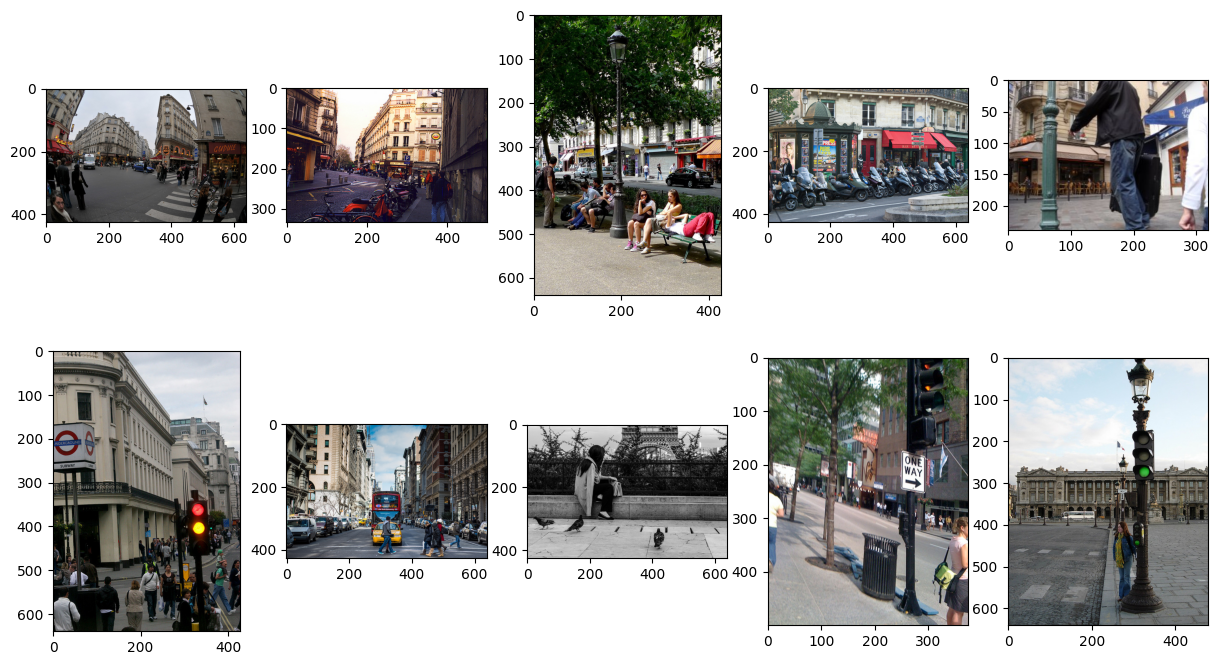

The score for searching "('person', 'bicycle')" is 65 %.


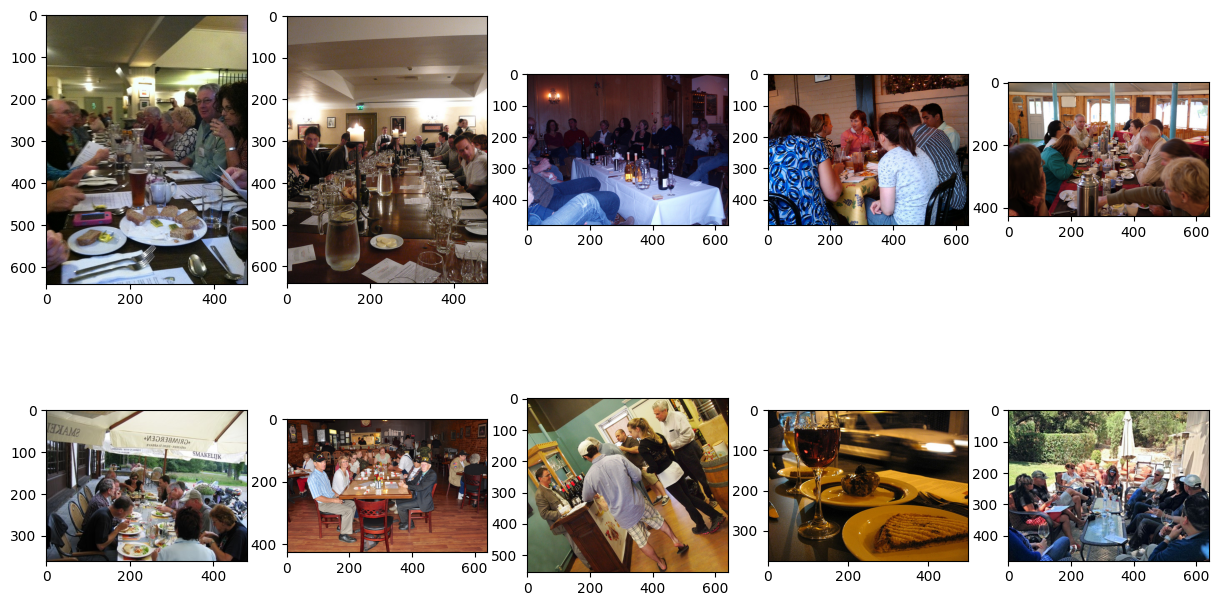

The score for searching "('cake', 'knife')" is 35 %.


In [13]:
for search_label, img_name in zip(image_search_labels, imgs_name):
    search_results = client.index("coco-2017-val").search(docker_path + img_name, 
                        searchable_attributes=['image_docker'], 
                         device='cpu')
    score = 0
    
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15,8))

    for i, result in enumerate(search_results["hits"]):
        img_name = result["image_docker"]
        local_path_img_name = img_name.replace(docker_path, images_directory)
        img = Image.open(local_path_img_name)
        axes[i//5,i%5].imshow(img)
    plt.show()
    
    
    
    for result in search_results["hits"]:
        img_id = int(result["_id"][6:12])
        anns = coco.loadAnns(coco.getAnnIds(imgIds = img_id))
        result_cat = []
        for an in anns:
            cat = coco.loadCats(an["category_id"])[0]
            result_cat.append(cat['name'])
        
        score += 10 * len(set(search_label) & set(result_cat)) / len(search_label)
        
    print(f"The score for searching \"{search_label}\" is {round(score)} %.")
        

## Image to Text Search

Here, we use the captions provided by the image dataset as our dataset.

In [6]:
capFile='{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_cap=COCO(capFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [7]:
annIds = coco_cap.getAnnIds()
anns = coco_cap.loadAnns(annIds)


cap_documents = [{"Caption" : cap['caption'], "image_id" : cap['image_id']} for cap in anns]



In [8]:
index_name = 'coco-2017-cap'

client.delete_index(index_name)

settings = {
        "model": MODEL,
        "treat_urls_and_pointers_as_images": True,
        }
try:
    client.create_index(index_name, **settings)
except:
    client.delete_index(index_name)
    client.create_index(index_name, **settings)

In [ ]:
client.index('coco-2017-cap').add_documents(cap_documents, device='cpu', processes=4, client_batch_size= 1)

I clear the outputs to reduce the file size. 


The average time for each document is 55ms (client_batch_size = 50)
The average time for each document is 61ms (client_batch_size = 10)
The average time for each document is 128ms (client_batch_size = 1).

In [18]:
#just randomly select 100 images for search
images_id = coco.getImgIds()[222:322] 

### Image-to-Text search result

The way we compute score is straightforward. We use image to search captions along with images id. If the image we search is in the return image id list, we score 1. If not, we score 0.

A more complicated method is that if the image id is in top 5 hits, we score 1. If it is in top 10 (6-10) hits, we score 0.5. 

In [19]:
images_path = [docker_path + coco.loadImgs(image_id)[0]['file_name'] for image_id in images_id]

score = 0

for image_path, true_id in zip(images_path, images_id):
    image_to_text_search_results = client.index("coco-2017-cap").search(image_path, 
                            searchable_attributes=['Caption'], 
                             device='cpu')
    
    
    captions = [hit["Caption"] for hit in image_to_text_search_results["hits"]]
    searched_images_id = [hit["image_id"] for hit in image_to_text_search_results["hits"]]
    if true_id in searched_images_id:
        score += 1
    
print(f"We score {score} in image-to-text search problem.")

    

We score 91 in image-to-text search problem.
